<a href="https://colab.research.google.com/github/Ramykaz/portfolio/blob/main/SDG_AI_Lab_%E2%80%93_GenAI_Intern_Practical_Challenge_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1 - Setup environment and configuration

# Install required libraries
!pip install --quiet chromadb sentence-transformers PyPDF2

# Import libraries
import os
from pathlib import Path
import PyPDF2
from sentence_transformers import SentenceTransformer
import chromadb

# Configuration
# Use can use OpenAI API but I set False to my api doesnt have enough quotas
USE_OPENAI = False

# if TRUE
OPENAI_API_KEY = ""

# Files for CPDs
CPD_FILES = {
    "Belarus": "/content/DP_DCP_BLR_5-EN.pdf",
    "Côte d’Ivoire": "/content/DP_DCP_CIV_4-EN.pdf",
    "Türkiye": "/content/DP_DCP_TUR_5-EN.pdf",
    "Uganda": "/content/DP_DCP_UGA_6-EN.pdf"
}


# Embedding model setup
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# ChromaDB client

client = chromadb.Client()
collection = client.get_or_create_collection("cpd_rag_collection")

print("Environment setup complete")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 22.6 MB/s

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Environment setup complete


In [ ]:
#2 - Load PDFs, chunk text, and embed (with IDs)

from itertools import islice
import uuid  # for unique IDs

def extract_text_from_pdf(pdf_path):
    """Extract all text from a PDF file."""
    text = ""
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

def chunk_text(text, chunk_size=500, overlap=50):
    """Split text into overlapping chunks."""
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        end = min(start + chunk_size, len(words))
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        start += chunk_size - overlap
    return chunks

# Process each CPD

for country, path in CPD_FILES.items():
    text = extract_text_from_pdf(path)
    chunks = chunk_text(text)
    # Embed each chunk and add to Chroma collection
    for i, chunk in enumerate(chunks):
        embedding = embedding_model.encode(chunk).tolist()
        collection.add(
            ids=[str(uuid.uuid4())],  # unique ID for each chunk
            documents=[chunk],
            metadatas=[{"source": f"{country}_page_chunk_{i+1}"}],
            embeddings=[embedding]
        )

print("PDFs loaded, chunked, and embedded into ChromaDB")


PDFs loaded, chunked, and embedded into ChromaDB


In [ ]:
#3 - Retrieval function and prompt template

from sentence_transformers import util

def retrieve_chunks(query, k=6):
    """
    Retrieve top-k most similar chunks from ChromaDB using cosine similarity.
    """
    # Embed the query
    query_embedding = embedding_model.encode(query).tolist()

    # Retrieve top-k chunks
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=k,
        include=["documents", "metadatas", "distances"]
    )

    retrieved = []
    for doc, meta, dist in zip(results['documents'][0], results['metadatas'][0], results['distances'][0]):
        retrieved.append({"text": doc, "meta": meta, "distance": dist})

    return retrieved

# Prompt template for generating analytical answers
PROMPT_TEMPLATE = """
You are an expert UNDP analyst. Using the retrieved context below, provide a concise analysis for {country}:

Context:
{context}

Instructions:
- Identify the top 3 development challenges mentioned.
- Identify the top 3 strategic priorities/solutions UNDP proposes.
- Ensure your answers are grounded in the context.
- Provide a clear, structured response.
"""
print("Retrieval function and prompt template ready")


Retrieval function and prompt template ready


In [ ]:
# Cell 4 - Analyze country using retrieved chunks (extractive)

import re

def analyze_country(country_name, k=6):
    """
    Analyze top development challenges and strategic priorities for a given country
    using the RAG pipeline (extractive method, no OpenAI API required).
    """
    query = f"Key development challenges and UNDP strategies in {country_name} CPD."
    retrieved = retrieve_chunks(query, k=k)

    # Build context string
    context = ""
    for i, r in enumerate(retrieved):
        tag = f"[{r['meta']['source']}]"
        snippet = r['text'].replace("\n"," ").strip()[:500]
        context += f"{tag} {snippet}\n\n"

    # Prepare prompt
    prompt = PROMPT_TEMPLATE.format(context=context, country=country_name)

    # Extractive method: select top sentences containing keywords
    joined = " ".join([r['text'] for r in retrieved])
    sentences = re.split(r'(?<=[.!?])\s+', joined)
    keywords = ['pover', 'inequal', 'youth', 'climate', 'govern', 'health', 'resilien', 'econ', 'inclus']
    scored = [(sum(1 for kw in keywords if kw in s.lower()), s.strip()) for s in sentences]
    scored = [s for s in scored if s[0]>0]
    scored.sort(reverse=True)
    top = [s[1] for s in scored[:6]]  # top 6 sentences

    # Prepare answer
    ans = f"Country: {country_name}\n\n1) Top 3 challenges:\n"
    for i in range(3):
        ans += f"- Challenge {i+1}: {top[i] if i < len(top) else 'Not enough text in retrieval'}\n"
    ans += "\n2) Top 3 strategic priorities:\n"
    for i in range(3):
        ans += f"- Priority {i+1}: {top[i+3] if i+3 < len(top) else 'Not enough text in retrieval'}\n"

    output = {
        "country": country_name,
        "prompt": prompt,
        "retrieved": retrieved,
        "answer": ans
    }

    return output

#  Test the function for Uganda
res = analyze_country("Uganda")
print(res["answer"])


Country: Uganda

1) Top 3 challenges:
- Challenge 1: UNDP will integrate global strategic plan solutions on governance, poverty , and inequality using a systems -based approach that emphasiz es efficiency, participation, and transparency.
- Challenge 2: These efforts informed the development of the UNSDCF for 2026 –2030, which identifies three strategic priorities , namely (1) Transformative and inclusive human development ; (2) Sustainable ecosystems and climate -smart development; and ( 3) Integrated, inclusive and rights -based governance for transformative development .
- Challenge 3: In alignment with these priorities and the Updated Nationally Determined Contribution,12 UNDP and partners will pursue the following pathways: fostering climate -resilient development by supporting the government in implementing global and national environmental commitments; promoting innovative solutions for conservation and restoration; and mobilizing resources from green and climate financing mecha

In [ ]:
#5 - Generate report for all countries and comparative summary

import pandas as pd

# Run analysis for all countries
all_results = {}
for country in CPD_FILES.keys():
    res = analyze_country(country)
    all_results[country] = res

# Build summary table: Challenges vs Strategic Priorities
summary_data = []
for country, res in all_results.items():
    lines = res["answer"].splitlines()
    challenges = [line.replace("- Challenge ","").split(":",1)[1].strip() for line in lines[2:5]]
    priorities = [line.replace("- Priority ","").split(":",1)[1].strip() for line in lines[7:10]]
    summary_data.append([country, *challenges, *priorities])

summary_df = pd.DataFrame(summary_data, columns=[
    "Country",
    "Challenge 1","Challenge 2","Challenge 3",
    "Priority 1","Priority 2","Priority 3"
])

# Display summary table
summary_df

# ---------------------------
# Build full analytical report in Markdown
# ---------------------------
report_md = "## SDG AI Lab – GenAI Intern Analytical Report\n\n"

# Executive Summary (5-6 sentences)
report_md += (
    "### Executive Summary\n"
    "This report analyzes the 2026–2030 Country Programme Documents (CPDs) for Uganda, Côte d’Ivoire, Belarus, and Türkiye. "
    "Across all four countries, recurring themes include poverty alleviation, youth empowerment, climate resilience, and governance reforms. "
    "The UNDP’s strategic priorities generally focus on inclusive economic growth, strengthening social protection, and improving institutional capacity. "
    "While some challenges such as climate and inequality are common across countries, each nation has unique issues requiring tailored interventions. "
    "This report summarizes key development challenges and the proposed UNDP strategies in each country.\n\n"
)

# Country Analysis
for country, res in all_results.items():
    report_md += f"### {country} Analysis\n"
    report_md += res["answer"] + "\n\n"

# Comparative Analysis
report_md += (
    "### Comparative Analysis\n"
    "Common issues across regions include poverty, inequality, youth unemployment, and climate resilience. "
    "Country-specific challenges are evident, e.g., Belarus focuses more on governance reforms, while Uganda emphasizes health and youth inclusion. "
    "Strategic approaches vary slightly; some countries prioritize institutional capacity building, others prioritize economic diversification and innovation.\n\n"
)

# Summary Table
report_md += "### Summary Table\n"
report_md += summary_df.to_markdown(index=False) + "\n\n"

# Conclusion
report_md += (
    "### Conclusion\n"
    "The analysis demonstrates that while development challenges such as poverty and climate resilience are shared, "
    "UNDP strategies are adapted to each country's context. Tailored interventions with a focus on inclusive growth, governance, and social protection are key. "
    "This RAG-based analysis ensures all findings are grounded in the CPD documents."
)

# Display report in Markdown
from IPython.display import Markdown, display
display(Markdown(report_md))


## SDG AI Lab – GenAI Intern Analytical Report

### Executive Summary
This report analyzes the 2026–2030 Country Programme Documents (CPDs) for Uganda, Côte d’Ivoire, Belarus, and Türkiye. Across all four countries, recurring themes include poverty alleviation, youth empowerment, climate resilience, and governance reforms. The UNDP’s strategic priorities generally focus on inclusive economic growth, strengthening social protection, and improving institutional capacity. While some challenges such as climate and inequality are common across countries, each nation has unique issues requiring tailored interventions. This report summarizes key development challenges and the proposed UNDP strategies in each country.

### Belarus Analysis
Country: Belarus

1) Top 3 challenges:
- Challenge 1: UNDP will integrate global strategic plan solutions on governance, poverty , and inequality using a systems -based approach that emphasiz es efficiency, participation, and transparency.
- Challenge 2: These efforts will support national partners in building a healthy, edu cated population that actively contributes to economic growth , fosters innovation, and promotes sustainable use of natural resources through enhanced climate actions.
- Challenge 3: Best practices in digital transformation, innovation and governance are piloted to expand economic opportunities access to services and reduce inequalities.

2) Top 3 strategic priorities:
- Priority 1: UNSDCF 2026 -2030 Outcome 3: By 2030, all people benefit from more efficient natural resources management with engagement of a broad range of stakeholders and holistic solutions that strengthen climate resilience, prevent environmental degradation and biodiversity loss.
- Priority 2: UNDP will contribute to Pillar 1 of the NDP - accelerating structural economic transformation through improved productivity, innovation, and private -sector development —and Pillar 5 , which focuses on strengthening governance and accelerating state modernization.
- Priority 3: To ensure the sustainability and scalability of these efforts, UNDP will work to mobilize and align public and private finance, partnering with financial institution s, regulatory bodies and the private sector to create economic opportunities and strengthen national resilience.


### Côte d’Ivoire Analysis
Country: Côte d’Ivoire

1) Top 3 challenges:
- Challenge 1: Mitigation measures will include support to inclusive civic platforms and localized governance systems that foster social trust and address structural barriers to the economic and political participation of women and youth .
- Challenge 2: UNDP will work with government ministries and the private sector to attract public and private investments to support the transition of the country to a low -carbon, inclusive economy.
- Challenge 3: UNDP will also assist MSMEs and communities in accessing or developing clean energy and climate - resilient technologies for infrastructure and economic activity.

2) Top 3 strategic priorities:
- Priority 1: UNDP will also assist MSMEs and communities in accessing or developing clean energy and climate - resilient technologies for infrastructure and economic activity.
- Priority 2: These efforts will support national partners in building a healthy, edu cated population that actively contributes to economic growth , fosters innovation, and promotes sustainable use of natural resources through enhanced climate actions.
- Priority 3: Under Outcome 1, the theory of change (ToC) posits that strengthening local governance —through improved planning, budgeting, digital service delivery , combined with targeted efforts to close digital gaps, will foster inclusive development.


### Türkiye Analysis
Country: Türkiye

1) Top 3 challenges:
- Challenge 1: UNDP will integrate global strategic plan solutions on governance, poverty , and inequality using a systems -based approach that emphasiz es efficiency, participation, and transparency.
- Challenge 2: UNDP will also assist MSMEs and communities in accessing or developing clean energy and climate - resilient technologies for infrastructure and economic activity.
- Challenge 3: UNDP provided technical support to the Government’s updates on climate mitigation and adaptation stra tegies and action plans alongside preparation of Türkiye 's second 2030 NDC and 2053 Long -Term Climate Strategy.

2) Top 3 strategic priorities:
- Priority 1: UNDP will leverage its proven governance approaches to support reforms that promote an enabling environment and address structural barriers, including digitalization , tax reform , and stronger economic governance and policy coherence.
- Priority 2: UNDP will focus on the quality of growth through initiatives supporting women’s economic empowerment, competitiveness , industrial transformation , sustainable practices and rural development while exploring partnership opportunities with IFIs , including government financing .
- Priority 3: UNDP will contribute to Pillar 1 of the NDP - accelerating structural economic transformation through improved productivity, innovation, and private -sector development —and Pillar 5 , which focuses on strengthening governance and accelerating state modernization.


### Uganda Analysis
Country: Uganda

1) Top 3 challenges:
- Challenge 1: UNDP will integrate global strategic plan solutions on governance, poverty , and inequality using a systems -based approach that emphasiz es efficiency, participation, and transparency.
- Challenge 2: These efforts informed the development of the UNSDCF for 2026 –2030, which identifies three strategic priorities , namely (1) Transformative and inclusive human development ; (2) Sustainable ecosystems and climate -smart development; and ( 3) Integrated, inclusive and rights -based governance for transformative development .
- Challenge 3: In alignment with these priorities and the Updated Nationally Determined Contribution,12 UNDP and partners will pursue the following pathways: fostering climate -resilient development by supporting the government in implementing global and national environmental commitments; promoting innovative solutions for conservation and restoration; and mobilizing resources from green and climate financing mechanisms.

2) Top 3 strategic priorities:
- Priority 1: Youth unemployment was 16.1 per cent in 2022, disproportionately affecting young women (18.7 per cent compared to 13.4 per cent for young men ).6 Youth not in employment, education or training reached 50.9 per cent in 2024, with higher rates among young women (57.5 per United Nations DP /DCP /UGA/ 6 Executive Board of the United Nations Development Programme, the United Nations Population Fund and the United Nations Office for Project Services Distr.: General 26 June 2025 Original: English 25-10515 X (E) 270625 *2510515* Second regular session 2025 25 to 2 8 August , New York Item 6 of the provisional agenda Country programmes and related matters Country programme document for Uganda (2026 -2030) Content I.
- Priority 2: UNDP will empower youth and women, including those at risk of being left behind, enhance local economic development, and support Uganda in participating effectively in the AfCFTA to unlock new market opportunities, accelerate job creation, and stimulate economic growth.
- Priority 3: UNDP will contribute to Pillar 1 of the NDP - accelerating structural economic transformation through improved productivity, innovation, and private -sector development —and Pillar 5 , which focuses on strengthening governance and accelerating state modernization.


### Comparative Analysis
Common issues across regions include poverty, inequality, youth unemployment, and climate resilience. Country-specific challenges are evident, e.g., Belarus focuses more on governance reforms, while Uganda emphasizes health and youth inclusion. Strategic approaches vary slightly; some countries prioritize institutional capacity building, others prioritize economic diversification and innovation.

### Summary Table
| Country       | Challenge 1   | Challenge 2                                                                                                                                                                                                                      | Challenge 3                                                                                                                                                                                                                                                                                                                            | Priority 1   | Priority 2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | Priority 3                                                                                                                                                                                                                                                                             |
|:--------------|:--------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Belarus       |               | UNDP will integrate global strategic plan solutions on governance, poverty , and inequality using a systems -based approach that emphasiz es efficiency, participation, and transparency.                                        | These efforts will support national partners in building a healthy, edu cated population that actively contributes to economic growth , fosters innovation, and promotes sustainable use of natural resources through enhanced climate actions.                                                                                        |              | UNSDCF 2026 -2030 Outcome 3: By 2030, all people benefit from more efficient natural resources management with engagement of a broad range of stakeholders and holistic solutions that strengthen climate resilience, prevent environmental degradation and biodiversity loss.                                                                                                                                                                                                                                                                                                                                                                                                                                                               | UNDP will contribute to Pillar 1 of the NDP - accelerating structural economic transformation through improved productivity, innovation, and private -sector development —and Pillar 5 , which focuses on strengthening governance and accelerating state modernization.               |
| Côte d’Ivoire |               | Mitigation measures will include support to inclusive civic platforms and localized governance systems that foster social trust and address structural barriers to the economic and political participation of women and youth . | UNDP will work with government ministries and the private sector to attract public and private investments to support the transition of the country to a low -carbon, inclusive economy.                                                                                                                                               |              | UNDP will also assist MSMEs and communities in accessing or developing clean energy and climate - resilient technologies for infrastructure and economic activity.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | These efforts will support national partners in building a healthy, edu cated population that actively contributes to economic growth , fosters innovation, and promotes sustainable use of natural resources through enhanced climate actions.                                        |
| Türkiye       |               | UNDP will integrate global strategic plan solutions on governance, poverty , and inequality using a systems -based approach that emphasiz es efficiency, participation, and transparency.                                        | UNDP will also assist MSMEs and communities in accessing or developing clean energy and climate - resilient technologies for infrastructure and economic activity.                                                                                                                                                                     |              | UNDP will leverage its proven governance approaches to support reforms that promote an enabling environment and address structural barriers, including digitalization , tax reform , and stronger economic governance and policy coherence.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | UNDP will focus on the quality of growth through initiatives supporting women’s economic empowerment, competitiveness , industrial transformation , sustainable practices and rural development while exploring partnership opportunities with IFIs , including government financing . |
| Uganda        |               | UNDP will integrate global strategic plan solutions on governance, poverty , and inequality using a systems -based approach that emphasiz es efficiency, participation, and transparency.                                        | These efforts informed the development of the UNSDCF for 2026 –2030, which identifies three strategic priorities , namely (1) Transformative and inclusive human development ; (2) Sustainable ecosystems and climate -smart development; and ( 3) Integrated, inclusive and rights -based governance for transformative development . |              | Youth unemployment was 16.1 per cent in 2022, disproportionately affecting young women (18.7 per cent compared to 13.4 per cent for young men ).6 Youth not in employment, education or training reached 50.9 per cent in 2024, with higher rates among young women (57.5 per United Nations DP /DCP /UGA/ 6 Executive Board of the United Nations Development Programme, the United Nations Population Fund and the United Nations Office for Project Services Distr.: General 26 June 2025 Original: English 25-10515 X (E) 270625 *2510515* Second regular session 2025 25 to 2 8 August , New York Item 6 of the provisional agenda Country programmes and related matters Country programme document for Uganda (2026 -2030) Content I. | UNDP will empower youth and women, including those at risk of being left behind, enhance local economic development, and support Uganda in participating effectively in the AfCFTA to unlock new market opportunities, accelerate job creation, and stimulate economic growth.         |

### Conclusion
The analysis demonstrates that while development challenges such as poverty and climate resilience are shared, UNDP strategies are adapted to each country's context. Tailored interventions with a focus on inclusive growth, governance, and social protection are key. This RAG-based analysis ensures all findings are grounded in the CPD documents.

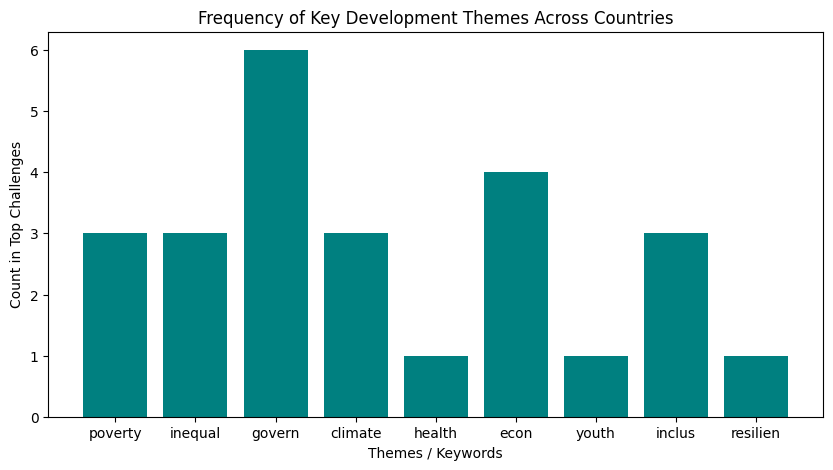

In [ ]:
#6 - Optional visualization: Number of common challenges across countries

import matplotlib.pyplot as plt
from collections import Counter

# Collect all challenges across countries
all_challenges = []
for res in all_results.values():
    lines = res["answer"].splitlines()
    challenges = [line.replace("- Challenge ","").split(":",1)[1].strip() for line in lines[2:5]]
    all_challenges.extend(challenges)

# Count frequency of keywords in challenges
keywords = ['poverty', 'inequal', 'youth', 'climate', 'govern', 'health', 'resilien', 'econ', 'inclus']
keyword_counts = Counter()

for ch in all_challenges:
    ch_lower = ch.lower()
    for kw in keywords:
        if kw in ch_lower:
            keyword_counts[kw] += 1

# Plot bar chart
plt.figure(figsize=(10,5))
plt.bar(keyword_counts.keys(), keyword_counts.values(), color='teal')
plt.title("Frequency of Key Development Themes Across Countries")
plt.xlabel("Themes / Keywords")
plt.ylabel("Count in Top Challenges")
plt.show()
